# Luis Martins
**Student Number:** 2025053
**Programme:** HDip in Sci in Data Analytics for Business
**GitHub:** [https://github.com/CCT-Dublin/ca1-50-LuiisClaudio](https://github.com/CCT-Dublin/ca1-50-LuiisClaudio)

**Date:** October 31, 2025

---

> **Dr. Muhammad Iqbal**
>
> CCT College Dublin
>
> **Module:** Machine Learning for Business

---

## Step 1: Import Necessary Libraries

First, we import all the Python libraries we'll need for data loading, cleaning, and transformation.

In [1]:
import pandas as pd
import numpy as np

## Step 2: Load the Data

We load the `PPR-ALL.csv` file into a pandas DataFrame. It's important to set `low_memory=False` to avoid mixed-type warnings due to the size of the dataset.

In [2]:
# Define the file path
file_path = 'PPR-ALL.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)


## Step 3: Initial Data Inspection

Let's get a first look at our data to understand its structure, identify data types, and find any obvious issues like missing values.

In [3]:
df.head()

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,NaN,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,NaN,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,04/01/2010,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,NaN,"438,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,04/01/2010,"1 The Haven, Mornington",Meath,NaN,"400,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,04/01/2010,"11 Melville Heights, Kilkenny",Kilkenny,NaN,"160,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


In [4]:
# Get a summary of the DataFrame (data types, non-null counts)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748893 entries, 0 to 748892
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Date of Sale (dd/mm/yyyy)  748893 non-null  object
 1   Address                    748893 non-null  object
 2   County                     748893 non-null  object
 3   Eircode                    206320 non-null  object
 4   Price ()                  748893 non-null  object
 5   Not Full Market Price      748893 non-null  object
 6   VAT Exclusive              748893 non-null  object
 7   Description of Property    748893 non-null  object
 8   Property Size Description  52834 non-null   object
dtypes: object(9)
memory usage: 51.4+ MB


In [5]:
# Check for the number of missing values (represented as nulls or empty strings)
print("\nMissing Value Counts:")
for col in df.columns:
    # Check for standard NaN values
    null_count = df[col].isnull().sum()
    
    # Check for empty strings "" which seem to be used for missing data
    empty_string_count = (df[col] == '""').sum() + (df[col] == '').sum() + (df[col] == ' ').sum()
    
    print(f"{col}: {null_count + empty_string_count} missing values")


Missing Value Counts:
Date of Sale (dd/mm/yyyy): 0 missing values
Address: 0 missing values
County: 0 missing values
Eircode: 542573 missing values
Price (): 0 missing values
Not Full Market Price: 0 missing values
VAT Exclusive: 0 missing values
Description of Property: 0 missing values
Property Size Description: 696059 missing values


### Initial Findings:

1.  **Target Variable:** `Price (€)` is an `object` (string) type. It contains '€' and ',' characters. It must be converted to a numeric type (float) to be used as a target for regression.
2.  **Date:** `Date of Sale (dd/mm/yyyy)` is an `object`. This should be converted to a datetime object so we can extract features like `Year` and `Month`, which likely influence price.
3.  **Missing Data:**
    * `Eircode` and `Property Size Description` have a very large number of missing values (represented as empty strings `""` in the CSV snippet).
4.  **Categorical Data:** `County`, `Not Full Market Price`, `VAT Exclusive`, and `Description of Property` are all `object` types and will need to be encoded.
5.  **High Cardinality:** `Address` and `Eircode` have too many unique values to be used directly in one-hot encoding. `Address` is free-text, and `Eircode` is sparse. We will likely drop these to simplify the model.

## Step 4: Data Cleaning & Feature Engineering

In [6]:
df.head()

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,NaN,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,NaN,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,04/01/2010,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,NaN,"438,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,04/01/2010,"1 The Haven, Mornington",Meath,NaN,"400,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,04/01/2010,"11 Melville Heights, Kilkenny",Kilkenny,NaN,"160,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


In [7]:
# Filter the data to include only properties in County Dublin, Cork, and Galway
df = df[df['County'].isin(['Dublin', 'Cork', 'Galway'])].copy()

print(f"Number of properties in Dublin, Cork, and Galway: {df.shape[0]}")
print("\nBreakdown by county:")
print(df['County'].value_counts())

Number of properties in Dublin, Cork, and Galway: 353750

Breakdown by county:
County
Dublin    234881
Cork       82637
Galway     36232
Name: count, dtype: int64


In [8]:
# Filter the original dataframe for properties sold in 2024 and 2025
#df = df[(df['Date of Sale (dd/mm/yyyy)'].str.contains('/2025'))].copy() #str.contains('/2024|/2025'))].copy()

#print(f"Number of properties sold in 2025: {df.shape[0]}")
#df.head()

### 4.1. Clean Target Variable: `Price`

# ----------------- Limiting the amout of row to test the algo faster

In [9]:
# Create a copy to avoid SettingWithCopyWarning
#data = df.head(5000).copy()
data = df.copy()

# Rename columns to be more Python-friendly (remove spaces, symbols)
data.columns = ['Date_of_Sale', 'Address', 'County', 'Eircode', 'Price', 
                  'Not_Full_Market_Price', 'VAT_Exclusive', 'Description_of_Property', 
                  'Property_Size_Description']

# Clean the 'Price' column
data['Price'] = data['Price'].astype(str).str.replace('€', '', regex=False).str.replace(',', '', regex=False).str.replace('', '', regex=False).str.strip()
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

print("Price column cleaned and converted to numeric.")
print(data['Price'].describe())

Price column cleaned and converted to numeric.
count    3.537500e+05
mean     4.082298e+05
std      1.546632e+06
min      5.030530e+03
25%      2.000000e+05
50%      3.000000e+05
75%      4.350000e+05
max      2.250000e+08
Name: Price, dtype: float64


### 4.2. Feature Engineering: `Date_of_Sale`

In [10]:
# Convert 'Date_of_Sale' to datetime objects
data['Date_of_Sale'] = pd.to_datetime(data['Date_of_Sale'], format='%d/%m/%Y')

# Extract 'Year' and 'Month' as new features
data['Sale_Year'] = data['Date_of_Sale'].dt.year
data['Sale_Month'] = data['Date_of_Sale'].dt.month

print("New features 'Sale_Year' and 'Sale_Month' created.")
data[['Date_of_Sale', 'Sale_Year', 'Sale_Month']].head()

New features 'Sale_Year' and 'Sale_Month' created.


,Date_of_Sale,Sale_Year,Sale_Month
0,2010-01-01,2010,1
2,2010-01-04,2010,1
5,2010-01-04,2010,1
8,2010-01-04,2010,1
11,2010-01-04,2010,1


### 4.3. Handle Other Categorical Features & Missing Values

We will clean up the string values and fill missing values (`""`) with a consistent 'Unknown' category. This prepares them for one-hot encoding.

In [11]:
# Clean and impute 'Description_of_Property'
# Replace empty/whitespace strings with 'Unknown'
data['Description_of_Property'] = data['Description_of_Property'].replace(['""', '', ' '], 'Unknown')
# Fill standard NaNs with 'Unknown' as well
data['Description_of_Property'] = data['Description_of_Property'].fillna('Unknown')
# There are two variations of 'New Dwelling...' in the data, let's standardize them.
data['Description_of_Property'] = data['Description_of_Property'].replace({
    'New Dwelling house /Apartment': 'New Dwelling',
    'Second-Hand Dwelling house /Apartment': 'Second-Hand Dwelling',
    'Teach/Árasán Cónaithe Nua': 'New Dwelling',
    'Teach/?ras?n C?naithe Nua': 'New Dwelling',
    'Teach/Árasán Cónaithe Atháimhe': 'Second-Hand Dwelling'
})


# Clean and impute 'County'
data['County'] = data['County'].fillna('Unknown')

print("Categorical columns cleaned and missing values imputed with 'Unknown'.")
print("\nUnique values in 'Description_of_Property':")
print(data['Description_of_Property'].value_counts())

Categorical columns cleaned and missing values imputed with 'Unknown'.

Unique values in 'Description_of_Property':
Description_of_Property
Second-Hand Dwelling    291944
New Dwelling             61806
Name: count, dtype: int64


### 4.4. Clean Binary Categorical Features

We'll convert the 'Yes'/'No' columns to integers (1/0).

In [12]:
data['Not_Full_Market_Price'] = data['Not_Full_Market_Price'].map({'Yes': 1, 'No': 0})
data['VAT_Exclusive'] = data['VAT_Exclusive'].map({'Yes': 1, 'No': 0})
data['Description_of_Property'] = data['Description_of_Property'].map({'New Dwelling': 1, 'Second-Hand Dwelling': 0})

print("Binary columns 'Not_Full_Market_Price', 'VAT_Exclusive', 'Description_of_Property' mapped to 1/0.")
data[['Not_Full_Market_Price', 'VAT_Exclusive', 'Description_of_Property']].head()

Binary columns 'Not_Full_Market_Price', 'VAT_Exclusive', 'Description_of_Property' mapped to 1/0.


,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property
0,0,0,0
2,0,0,0
5,0,0,0
8,0,0,0
11,0,0,0


### 4.5. Feature Selection: Dropping Unused Columns

In [13]:
columns_to_drop = ['Date_of_Sale', 'Address', 'Eircode', 'Property_Size_Description']
data_cleaned = data.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")
print("\nCleaned data head:")
data_cleaned.head()

Dropped columns: ['Date_of_Sale', 'Address', 'Eircode', 'Property_Size_Description']

Cleaned data head:


,County,Price,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property,Sale_Year,Sale_Month
0,Dublin,343000.0,0,0,0,2010,1
2,Dublin,438500.0,0,0,0,2010,1
5,Dublin,425000.0,0,0,0,2010,1
8,Cork,180000.0,0,0,0,2010,1
11,Dublin,430000.0,0,0,0,2010,1


### 4.6. Keeping or Not 'Not Full Market Price' 

For a price prediction model, sales that were **not** at full market price could skew the results. However, we're are keeping this feature... But if we wanna show more representative data, we should filter these out to train the model

In [14]:
original_rows = data_cleaned.shape[0]

# For now Im keeping Not_Full_Market_Price to feed to the model with my features
data_final = data_cleaned.copy() #[data_cleaned['Not_Full_Market_Price'] == 0].copy()
# Now that we've filtered, we can drop this column as it's no longer needed as a feature.
# data_final = data_final.drop(columns=['Not_Full_Market_Price'])

# Removing description of property because it is not relevant for our cluster analysis
# data_final = data_final.drop(columns=['Description_of_Property'])

data_ts_final = data_final.copy()

# Filter for properties sold in 2025
data_final = data_final[data_final['Sale_Year'].isin([2025])].copy()
print(f"Number of properties sold in 2025: {data_final.shape[0]}")
print("\nBreakdown by year:")
print(data_final['Sale_Year'].value_counts().sort_index())
data_final = data_final.head(5000) # Limit to first 5000 rows
data_final.head()


Number of properties sold in 2025: 20497

Breakdown by year:
Sale_Year
2025    20497
Name: count, dtype: int64


,County,Price,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property,Sale_Year,Sale_Month
705877,Dublin,239000.0,0,0,0,2025,1
705879,Dublin,326000.0,0,0,0,2025,1
705881,Cork,230000.0,0,0,0,2025,1
705882,Dublin,1050000.0,0,0,0,2025,1
705885,Cork,370000.0,0,0,0,2025,1


# Handle categorical data

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'County' column using LabelEncoder
label_encoder = LabelEncoder()
data_final['County_Encoded'] = label_encoder.fit_transform(data_final['County'])

# Drop the original 'County' column as we now have the encoded version
data_final = data_final.drop(columns=['County'])

# Show the mapping of counties to encoded values
county_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nCounty to Encoded Value Mapping:")
for county, encoded_value in sorted(county_mapping.items(), key=lambda x: x[1]):
    print(f"{county}: {encoded_value}")


County to Encoded Value Mapping:
Cork: 0
Dublin: 1
Galway: 2


In [16]:
# Show the final cleaned and encoded data
data_final.head(10)

,Price,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property,Sale_Year,Sale_Month,County_Encoded
705877,239000.0,0,0,0,2025,1,1
705879,326000.0,0,0,0,2025,1,1
705881,230000.0,0,0,0,2025,1,0
705882,1050000.0,0,0,0,2025,1,1
705885,370000.0,0,0,0,2025,1,0
705886,395000.0,0,0,0,2025,1,1
705888,340000.0,0,0,0,2025,1,1
705892,275000.0,0,0,0,2025,1,0
705894,1480000.0,0,0,0,2025,1,1
705901,100000.0,1,0,0,2025,1,0


## Define Features (X) and Target (y)

We separate our cleaned dataset into `X` (the features, or inputs) and `y` (the target, or output) which is the `Price`.

In [17]:
X = data_final.drop(columns=['Price'])
y = data_final['Price']

print(f"Features shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")

Features shape (X): (5000, 6)
Target shape (y): (5000,)


In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data to create a validation set (80% train, 20% validation of the training data)
# This gives us approximately 64% train, 16% validation, 20% test of the original data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Data split into Train, Validation, and Test sets:")
print(f"Training set - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set - X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set - X_test: {X_test.shape}, y_test: {y_test.shape}")


# Ensure all sets have the same columns (important after one-hot encoding)
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print("\nAfter one-hot encoding:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Data split into Train, Validation, and Test sets:
Training set - X_train: (3200, 6), y_train: (3200,)
Validation set - X_val: (800, 6), y_val: (800,)
Test set - X_test: (1000, 6), y_test: (1000,)

After one-hot encoding:
X_train shape: (3200, 6)
X_val shape: (800, 6)
X_test shape: (1000, 6)


In [19]:
X_train.head()

,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property,Sale_Year,Sale_Month,County_Encoded
712981,0,0,0,2025,2,1
710175,0,0,0,2025,2,0
713569,0,0,0,2025,3,1
711444,0,1,1,2025,2,1
710372,0,0,0,2025,2,1


# K-Means Algo

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
data_final_kmeans = data_final.copy()

# Select features for clustering: Price and Location (County)
features_for_clustering = data_final[['Price', 'County_Encoded', 'Description_of_Property']]

# Scale the features
scaler_segment = StandardScaler()
features_scaled = scaler_segment.fit_transform(features_for_clustering)

# Apply K-Means with k=6
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
data_final_kmeans['Market_Segment_Label'] = kmeans.fit_predict(features_scaled)

# Display the distribution of properties across the new segments
print("Distribution of properties across market segments:")
print(data_final_kmeans['Market_Segment_Label'].value_counts())

Distribution of properties across market segments:
Market_Segment_Label
1    2849
3     923
0     551
4     375
5     300
2       2
Name: count, dtype: int64


In [21]:
# Analyze the clusters to assign meaningful names
segment_price_analysis = data_final_kmeans.groupby('Market_Segment_Label')['Price'].mean().sort_values()

# Create a mapping from cluster label to segment name
segment_name_map = {
    segment_price_analysis.index[0]: 'Starter/Budget',
    segment_price_analysis.index[1]: 'Affordable Family',
    segment_price_analysis.index[2]: 'Mid-Range',
    segment_price_analysis.index[3]: 'Upper-Mid',
    segment_price_analysis.index[4]: 'Premium',
    segment_price_analysis.index[5]: 'Luxury'
}

# Apply the mapping
data_final_kmeans['Market_Segment'] = data_final_kmeans['Market_Segment_Label'].map(segment_name_map)

data_final_kmeans.head()

,Price,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property,Sale_Year,Sale_Month,County_Encoded,Market_Segment_Label,Market_Segment
705877,239000.0,0,0,0,2025,1,1,1,Premium
705879,326000.0,0,0,0,2025,1,1,1,Premium
705881,230000.0,0,0,0,2025,1,0,3,Affordable Family
705882,1050000.0,0,0,0,2025,1,1,1,Premium
705885,370000.0,0,0,0,2025,1,0,3,Affordable Family


In [22]:
# Display a statistical summary of price for each market segment
print("Price Summary by Market Segment:")
# Format the output for better readability
price_summary = data_final_kmeans.groupby('Market_Segment')['Price'].describe()
for col in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    price_summary[col] = price_summary[col].apply(lambda x: f"€{x:,.2f}")

price_summary

Price Summary by Market Segment:


,count,mean,std,min,25%,50%,75%,max
Market_Segment,,,,,,,,
Affordable Family,923.0,"€355,011.26","€222,484.50","€10,000.00","€225,000.00","€320,000.00","€435,500.00","€2,250,000.00"
Luxury,2.0,"€45,728,344.07","€16,156,512.11","€34,303,964.80","€40,016,154.44","€45,728,344.07","€51,440,533.70","€57,152,723.34"
Mid-Range,300.0,"€375,305.37","€136,051.77","€22,000.00","€311,385.75","€351,542.00","€414,096.23","€1,585,903.08"
Premium,2849.0,"€561,470.53","€401,039.06","€20,000.00","€345,000.00","€460,000.00","€650,000.00","€9,750,000.00"
Starter/Budget,375.0,"€343,475.10","€230,002.74","€5,500.00","€223,000.00","€310,000.00","€415,000.00","€3,025,000.00"
Upper-Mid,551.0,"€542,351.17","€372,613.26","€56,000.00","€383,260.00","€458,149.77","€599,118.47","€4,359,030.00"


In [23]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt

# K-means clustering evaluation metrics

ks = range(2, 25)  # evaluate k from 2 to 24
inertias = []
sil_scores = []
db_scores = []

features_for_clustering_all_features = data_final[['Price', 'Description_of_Property', 'County_Encoded']]

# Scale the features
scaler_segment = StandardScaler()
features_scaled = scaler_segment.fit_transform(features_for_clustering_all_features)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(features_for_clustering_all_features)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(features_for_clustering_all_features, labels))
    db_scores.append(davies_bouldin_score(features_for_clustering_all_features, labels))

# Print results
print("k\tInertia\t\tSilhouette\tDavies-Bouldin")
for k, i, s, d in zip(ks, inertias, sil_scores, db_scores):
    print(f"{k}\t{int(i):10d}\t{s:0.4f}\t\t{d:0.4f}")

# Select best k by each metric
best_k_sil = ks[int(np.argmax(sil_scores))]
best_k_db = ks[int(np.argmin(db_scores))]
print(f"\nBest k by silhouette score: {best_k_sil} (score={max(sil_scores):0.4f})")
print(f"Best k by Davies-Bouldin index: {best_k_db} (index={min(db_scores):0.4f})")



k	Inertia		Silhouette	Davies-Bouldin
2	911214397964619	0.9930		0.2573
3	582292946317178	0.7676		0.4487
4	321239906710101	0.7613		0.2795
5	197707473510967	0.6255		0.3448
6	135070379778185	0.5822		0.3862
7	85826419254977	0.5782		0.3149
8	57940945242177	0.5291		0.3479
9	43970056098494	0.5234		0.3746
10	33140769839814	0.5197		0.3484
11	25278953330593	0.5238		0.3612
12	18762966103161	0.5318		0.3701
13	15428318083747	0.5273		0.3736
14	12395818373776	0.5283		0.3801
15	10486084409861	0.5225		0.3936
16	8764056470258	0.5269		0.3981
17	7457358326177	0.5258		0.4108
18	6433696748626	0.5278		0.4138
19	5721923750144	0.5275		0.4151
20	5115425018288	0.5300		0.4147
21	4498384548068	0.5234		0.4229
22	4067654575488	0.5229		0.4232
23	3649313216314	0.5319		0.4285
24	3236921107475	0.5281		0.4226

Best k by silhouette score: 2 (score=0.9930)
Best k by Davies-Bouldin index: 2 (index=0.2573)


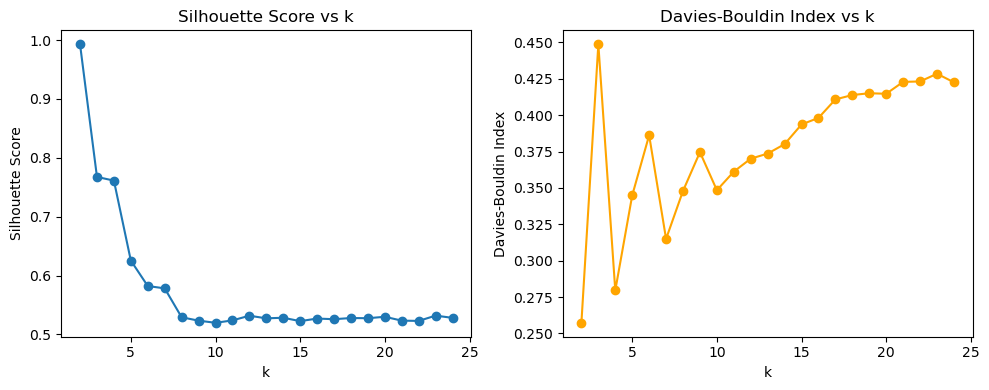


Cluster sizes for final model (chosen by silhouette):
Cluster 0: 4998 samples
Cluster 1: 2 samples


In [24]:
# Plot the metrics
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, sil_scores, marker='o')
plt.title('Silhouette Score vs k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')

plt.subplot(1,2,2)
plt.plot(ks, db_scores, marker='o', color='orange')
plt.title('Davies-Bouldin Index vs k')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Index')
plt.tight_layout()
plt.show()

# Fit final model for the silhouette-optimal k and show cluster sizes
final_k = best_k_sil
final_km = KMeans(n_clusters=final_k, random_state=42, n_init=10).fit(features_for_clustering_all_features)
final_labels = final_km.labels_
(unique, counts) = np.unique(final_labels, return_counts=True)
print("\nCluster sizes for final model (chosen by silhouette):")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# Choosing DBSCAN 

In [25]:
from sklearn.cluster import DBSCAN
# Apply DBSCAN with k=7
# Apply DBSCAN with parameters to approximate 7 clusters
# Based on the parameter tuning, we'll use eps and min_samples that give us close to 7 clusters

data_final_dbscan = data_final.copy()
dbscan = DBSCAN(eps=0.5, min_samples=5)
data_final_dbscan['Market_Segment_Label'] = dbscan.fit_predict(features_scaled)

# Display the distribution of properties across the new segments
print("Distribution of properties across market segments:")
print(data_final_dbscan['Market_Segment_Label'].value_counts().sort_index())
print(f"\nNumber of clusters (excluding noise): {len(set(data_final_dbscan['Market_Segment_Label'])) - (1 if -1 in data_final_dbscan['Market_Segment_Label'].values else 0)}")
print(f"Number of noise points: {(data_final_dbscan['Market_Segment_Label'] == -1).sum()}")

Distribution of properties across market segments:
Market_Segment_Label
-1      13
 0    2846
 1     922
 2     374
 3     300
 4     505
 5      40
Name: count, dtype: int64

Number of clusters (excluding noise): 6
Number of noise points: 13


In [26]:
# Analyze the clusters to assign meaningful names
segment_price_analysis = data_final_dbscan.groupby('Market_Segment_Label')['Price'].mean().sort_values()

# Create a mapping from cluster label to segment name
segment_name_map = {
    segment_price_analysis.index[0]: 'Starter/Budget',
    segment_price_analysis.index[1]: 'Affordable Family',
    segment_price_analysis.index[2]: 'Mid-Range',
    segment_price_analysis.index[3]: 'Upper-Mid',
    segment_price_analysis.index[4]: 'Premium',
    segment_price_analysis.index[5]: 'Luxury'
}

# Apply the mapping
data_final_dbscan['Market_Segment'] = data_final_dbscan['Market_Segment_Label'].map(segment_name_map)

data_final_dbscan.head()

,Price,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property,Sale_Year,Sale_Month,County_Encoded,Market_Segment_Label,Market_Segment
705877,239000.0,0,0,0,2025,1,1,0,Luxury
705879,326000.0,0,0,0,2025,1,1,0,Luxury
705881,230000.0,0,0,0,2025,1,0,1,Affordable Family
705882,1050000.0,0,0,0,2025,1,1,0,Luxury
705885,370000.0,0,0,0,2025,1,0,1,Affordable Family


In [27]:
# Display a statistical summary of price for each market segment
print("Price Summary by Market Segment:")
# Format the output for better readability
price_summary = data_final_dbscan.groupby('Market_Segment')['Price'].describe()
for col in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    price_summary[col] = price_summary[col].apply(lambda x: f"€{x:,.2f}")

price_summary

Price Summary by Market Segment:


,count,mean,std,min,25%,50%,75%,max
Market_Segment,,,,,,,,
Affordable Family,922.0,"€352,955.95","€213,658.29","€10,000.00","€225,000.00","€320,000.00","€435,000.00","€1,595,000.00"
Luxury,2846.0,"€555,895.83","€351,357.59","€20,000.00","€345,000.00","€460,000.00","€645,750.00","€3,080,000.00"
Mid-Range,40.0,"€354,446.43","€113,507.31","€207,048.46","€264,317.18","€330,396.48","€389,867.84","€690,528.63"
Premium,505.0,"€524,107.96","€217,039.79","€56,000.00","€396,475.77","€466,960.35","€607,900.00","€1,585,903.00"
Starter/Budget,374.0,"€336,305.25","€183,613.34","€5,500.00","€223,000.00","€310,000.00","€413,750.00","€1,125,000.00"
Upper-Mid,300.0,"€375,305.37","€136,051.77","€22,000.00","€311,385.75","€351,542.00","€414,096.23","€1,585,903.08"


In [28]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

import matplotlib.pyplot as plt

# DBSCAN clustering with different parameter combinations
# We'll test different eps and min_samples values

# Use the scaled features from previous cell
dbscan_features_scaled = features_scaled
# Test different eps values (distance threshold)
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
min_samples_values = [5, 10, 15, 20]

results = []

print("DBSCAN Parameter Tuning Results:")
print("="*80)
print(f"{'eps':<8}{'min_samples':<15}{'n_clusters':<15}{'n_noise':<12}{'Silhouette':<15}{'Davies-Bouldin'}")
print("="*80)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(dbscan_features_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Only compute metrics if we have at least 2 clusters and not all points are noise
        if n_clusters >= 2 and n_noise < len(labels):
            # Exclude noise points (label -1) for metric calculation
            mask = labels != -1
            if sum(mask) > 0:
                sil_score = silhouette_score(dbscan_features_scaled[mask], labels[mask])
                db_score = davies_bouldin_score(dbscan_features_scaled[mask], labels[mask])
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': sil_score,
                    'davies_bouldin': db_score
                })
                print(f"{eps:<8.1f}{min_samples:<15}{n_clusters:<15}{n_noise:<12}{sil_score:<15.4f}{db_score:.4f}")
            else:
                print(f"{eps:<8.1f}{min_samples:<15}{n_clusters:<15}{n_noise:<12}{'N/A':<15}{'N/A'}")
        else:
            print(f"{eps:<8.1f}{min_samples:<15}{n_clusters:<15}{n_noise:<12}{'N/A':<15}{'N/A'}")

# Find best parameters by silhouette score and Davies-Bouldin index
if results:
    best_sil = max(results, key=lambda x: x['silhouette'])
    best_db = min(results, key=lambda x: x['davies_bouldin'])
    
    print("\n" + "="*80)
    print(f"Best by Silhouette Score: eps={best_sil['eps']}, min_samples={best_sil['min_samples']}")
    print(f"  Clusters: {best_sil['n_clusters']}, Noise: {best_sil['n_noise']}, Score: {best_sil['silhouette']:.4f}")
    print(f"\nBest by Davies-Bouldin Index: eps={best_db['eps']}, min_samples={best_db['min_samples']}")
    print(f"  Clusters: {best_db['n_clusters']}, Noise: {best_db['n_noise']}, Index: {best_db['davies_bouldin']:.4f}")
    
    # Fit final DBSCAN model with best silhouette parameters
    final_dbscan = DBSCAN(eps=best_sil['eps'], min_samples=best_sil['min_samples'])
    final_labels = final_dbscan.fit_predict(dbscan_features_scaled)
    
    # Show cluster distribution
    unique, counts = np.unique(final_labels, return_counts=True)
    print("\nFinal DBSCAN Cluster Distribution (best silhouette parameters):")
    for u, c in zip(unique, counts):
        if u == -1:
            print(f"Noise: {c} samples")
        else:
            print(f"Cluster {u}: {c} samples")

DBSCAN Parameter Tuning Results:
eps     min_samples    n_clusters     n_noise     Silhouette     Davies-Bouldin
0.5     5              6              13          0.8578         0.1701
0.5     10             6              14          0.8580         0.1697
0.5     15             6              15          0.8581         0.1694
0.5     20             6              15          0.8581         0.1694
1.0     5              6              7           0.8556         0.1750
1.0     10             6              7           0.8556         0.1750
1.0     15             6              8           0.8560         0.1736
1.0     20             6              8           0.8560         0.1736
1.5     5              6              5           0.8546         0.1793
1.5     10             6              5           0.8546         0.1793
1.5     15             6              6           0.8551         0.1770
1.5     20             6              6           0.8551         0.1770
2.0     5              

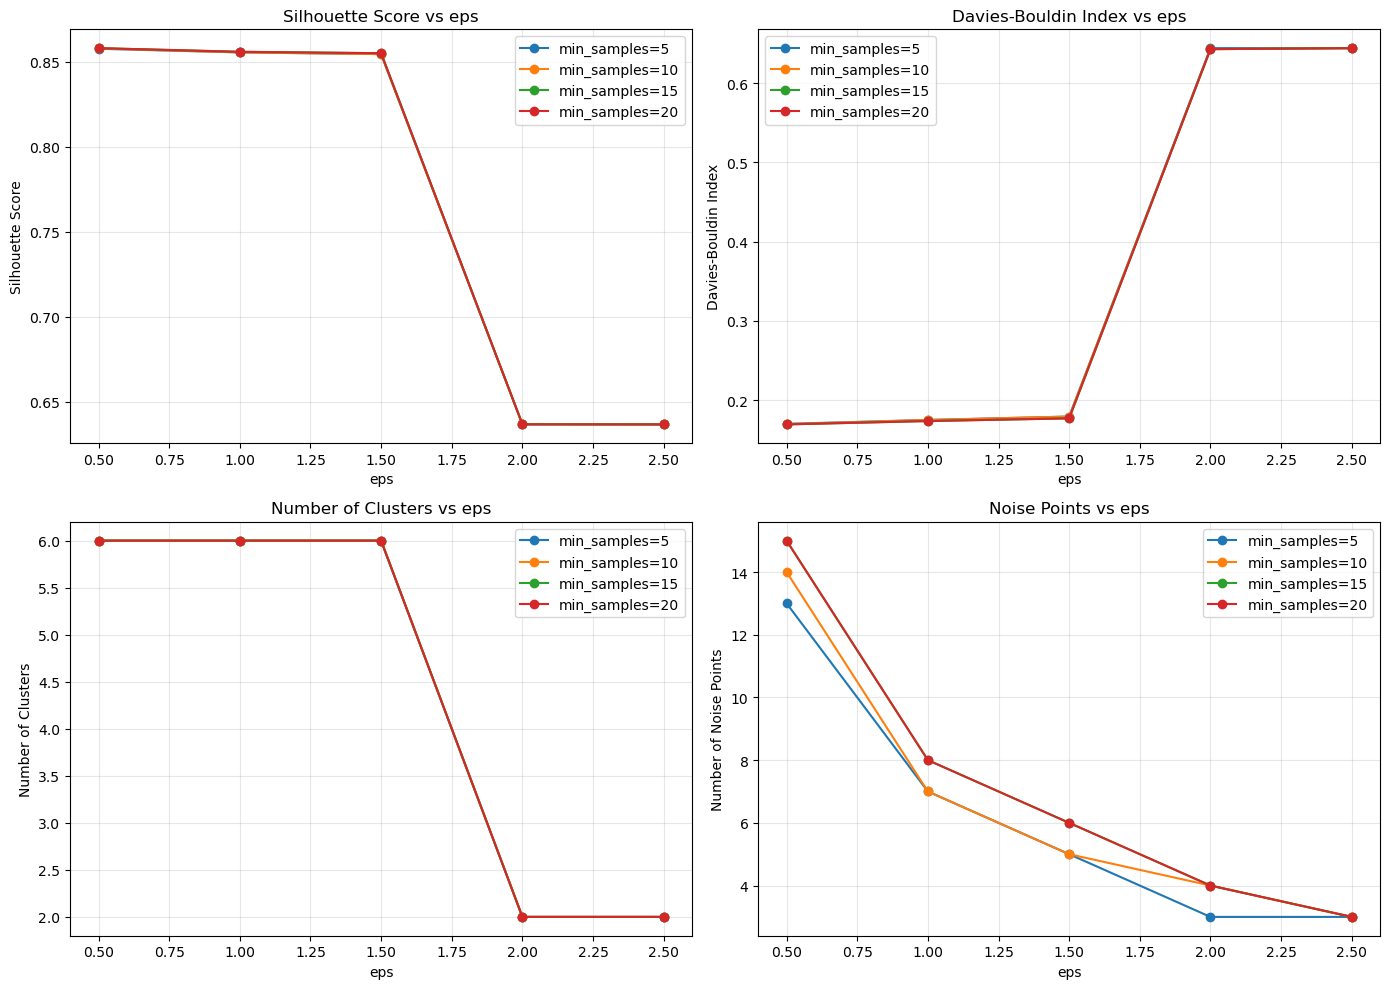


Cluster sizes for final model (chosen by silhouette):
Noise: 15 samples
Cluster 0: 2846 samples
Cluster 1: 922 samples
Cluster 2: 374 samples
Cluster 3: 298 samples
Cluster 4: 505 samples
Cluster 5: 40 samples


In [29]:
# Plot the metrics for DBSCAN parameter tuning
if results:
    # Extract data for plotting
    eps_list = [r['eps'] for r in results]
    min_samples_list = [r['min_samples'] for r in results]
    sil_list = [r['silhouette'] for r in results]
    db_list = [r['davies_bouldin'] for r in results]
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Silhouette Score vs eps (for each min_samples)
    for min_samp in min_samples_values:
        mask = [r['min_samples'] == min_samp for r in results]
        eps_subset = [results[i]['eps'] for i, m in enumerate(mask) if m]
        sil_subset = [results[i]['silhouette'] for i, m in enumerate(mask) if m]
        axes[0, 0].plot(eps_subset, sil_subset, marker='o', label=f'min_samples={min_samp}')
    axes[0, 0].set_title('Silhouette Score vs eps')
    axes[0, 0].set_xlabel('eps')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Davies-Bouldin Index vs eps
    for min_samp in min_samples_values:
        mask = [r['min_samples'] == min_samp for r in results]
        eps_subset = [results[i]['eps'] for i, m in enumerate(mask) if m]
        db_subset = [results[i]['davies_bouldin'] for i, m in enumerate(mask) if m]
        axes[0, 1].plot(eps_subset, db_subset, marker='o', label=f'min_samples={min_samp}')
    axes[0, 1].set_title('Davies-Bouldin Index vs eps')
    axes[0, 1].set_xlabel('eps')
    axes[0, 1].set_ylabel('Davies-Bouldin Index')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Plot 3: Number of clusters vs eps
    for min_samp in min_samples_values:
        mask = [r['min_samples'] == min_samp for r in results]
        eps_subset = [results[i]['eps'] for i, m in enumerate(mask) if m]
        n_clust_subset = [results[i]['n_clusters'] for i, m in enumerate(mask) if m]
        axes[1, 0].plot(eps_subset, n_clust_subset, marker='o', label=f'min_samples={min_samp}')
    axes[1, 0].set_title('Number of Clusters vs eps')
    axes[1, 0].set_xlabel('eps')
    axes[1, 0].set_ylabel('Number of Clusters')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Plot 4: Noise points vs eps
    for min_samp in min_samples_values:
        mask = [r['min_samples'] == min_samp for r in results]
        eps_subset = [results[i]['eps'] for i, m in enumerate(mask) if m]
        noise_subset = [results[i]['n_noise'] for i, m in enumerate(mask) if m]
        axes[1, 1].plot(eps_subset, noise_subset, marker='o', label=f'min_samples={min_samp}')
    axes[1, 1].set_title('Noise Points vs eps')
    axes[1, 1].set_xlabel('eps')
    axes[1, 1].set_ylabel('Number of Noise Points')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show cluster distribution for best silhouette parameters
    print("\nCluster sizes for final model (chosen by silhouette):")
    for u, c in zip(unique, counts):
        if u == -1:
            print(f"Noise: {c} samples")
        else:
            print(f"Cluster {u}: {c} samples")

# Fuzzy C-Means is Ideal for Property Market Segmentation

In [30]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from fcmeans import FCM as FuzzyCMeans

# Create a copy of the data
data_final_fuzzy = data_final.copy()

# Select features for clustering: Price, County, and Property Description
features_for_fuzzy = data_final[['Price', 'County_Encoded', 'Description_of_Property']]

# Scale the features
scaler_fuzzy = StandardScaler()
X_scaled = scaler_fuzzy.fit_transform(features_for_fuzzy)

# Apply Fuzzy C-Means with c=6 clusters
fuzzy_model = FuzzyCMeans(n_clusters=6, m=2, random_state=42, max_iter=150)
fuzzy_model.fit(X_scaled)

# Get hard cluster assignments (highest membership)
data_final_fuzzy['Market_Segment_Label'] = fuzzy_model.predict(X_scaled)

# Store membership values for analysis
data_final_fuzzy['Max_Membership'] = fuzzy_model.u.max(axis=1)

# Display the distribution of properties across the new segments
print("Distribution of properties across market segments:")
print(data_final_fuzzy['Market_Segment_Label'].value_counts().sort_index())
print(f"\nAverage membership strength: {data_final_fuzzy['Max_Membership'].mean():.4f}")

Distribution of properties across market segments:
Market_Segment_Label
0     300
1    2314
2     374
3     923
4     538
5     551
Name: count, dtype: int64

Average membership strength: 0.9253


In [31]:
# Analyze the clusters to assign meaningful names
segment_price_analysis = data_final_fuzzy.groupby('Market_Segment_Label')['Price'].mean().sort_values()

# Create a mapping from cluster label to segment name
segment_name_map = {
    segment_price_analysis.index[0]: 'Starter/Budget',
    segment_price_analysis.index[1]: 'Affordable Family',
    segment_price_analysis.index[2]: 'Mid-Range',
    segment_price_analysis.index[3]: 'Upper-Mid',
    segment_price_analysis.index[4]: 'Premium',
    segment_price_analysis.index[5]: 'Luxury'
}

# Apply the mapping
data_final_fuzzy['Market_Segment'] = data_final_fuzzy['Market_Segment_Label'].map(segment_name_map)

data_final_fuzzy.head()

,Price,Not_Full_Market_Price,VAT_Exclusive,Description_of_Property,Sale_Year,Sale_Month,County_Encoded,Market_Segment_Label,Max_Membership,Market_Segment
705877,239000.0,0,0,0,2025,1,1,1,0.928897,Upper-Mid
705879,326000.0,0,0,0,2025,1,1,1,0.976600,Upper-Mid
705881,230000.0,0,0,0,2025,1,0,3,0.989337,Affordable Family
705882,1050000.0,0,0,0,2025,1,1,4,0.999774,Luxury
705885,370000.0,0,0,0,2025,1,0,3,0.999300,Affordable Family


In [32]:
# Display a statistical summary of price for each market segment
print("Price Summary by Market Segment:")
# Format the output for better readability
price_summary = data_final_fuzzy.groupby('Market_Segment')['Price'].describe()
for col in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    price_summary[col] = price_summary[col].apply(lambda x: f"€{x:,.2f}")

price_summary

Price Summary by Market Segment:


,count,mean,std,min,25%,50%,75%,max
Market_Segment,,,,,,,,
Affordable Family,923.0,"€355,011.26","€222,484.50","€10,000.00","€225,000.00","€320,000.00","€435,500.00","€2,250,000.00"
Luxury,538.0,"€1,312,317.40","€2,867,364.42","€737,535.00","€817,875.00","€950,000.00","€1,255,000.00","€57,152,723.34"
Mid-Range,300.0,"€375,305.37","€136,051.77","€22,000.00","€311,385.75","€351,542.00","€414,096.23","€1,585,903.08"
Premium,551.0,"€542,351.17","€372,613.26","€56,000.00","€383,260.00","€458,149.77","€599,118.47","€4,359,030.00"
Starter/Budget,374.0,"€336,305.25","€183,613.34","€5,500.00","€223,000.00","€310,000.00","€413,750.00","€1,125,000.00"
Upper-Mid,2314.0,"€427,002.80","€139,482.89","€20,000.00","€325,000.00","€416,000.00","€527,375.00","€737,000.00"


In [33]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Fuzzy C-Means Implementation
import matplotlib.pyplot as plt

# Use the same scaled data
X_scaled_fcm = features_scaled.copy()

c_values = range(2, 25)  # number of clusters
fcm_inertias = []
fcm_sil_scores = []
fcm_db_scores = []

for c in c_values:
    fcm = FuzzyCMeans(n_clusters=c, m=2, random_state=42)
    fcm.fit(X_scaled_fcm)
    labels = fcm.predict(X_scaled_fcm)
    
    # Calculate metrics
    fcm_sil_scores.append(silhouette_score(X_scaled_fcm, labels))
    fcm_db_scores.append(davies_bouldin_score(X_scaled_fcm, labels))

# Print results
print("\nc\tSilhouette\tDavies-Bouldin")
for c, s, d in zip(c_values, fcm_sil_scores, fcm_db_scores):
    print(f"{c}\t{s:0.4f}\t\t{d:0.4f}")

# Select best c by each metric
best_c_sil = c_values[int(np.argmax(fcm_sil_scores))]
best_c_db = c_values[int(np.argmin(fcm_db_scores))]
print(f"\nBest c by silhouette score: {best_c_sil} (score={max(fcm_sil_scores):0.4f})")
print(f"Best c by Davies-Bouldin index: {best_c_db} (index={min(fcm_db_scores):0.4f})")

# Fit final FCM model
final_fcm = FuzzyCMeans(n_clusters=best_c_sil, m=2, random_state=42)
final_fcm.fit(X_scaled_fcm)
final_fcm_labels = final_fcm.predict(X_scaled_fcm)

# Show cluster distribution
unique, counts = np.unique(final_fcm_labels, return_counts=True)
print("\nFuzzy C-Means Cluster Distribution (best silhouette parameters):")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")


c	Silhouette	Davies-Bouldin
2	0.6395		0.6859
3	0.7160		0.5052
4	0.7929		0.4210
5	0.8323		0.2845
6	0.7486		0.4826
7	0.6988		0.7046
8	0.6401		0.6815
9	0.6132		0.6640
10	0.6733		0.8938
11	0.5812		1.1339
12	0.5428		1.0527
13	0.5250		0.9308
14	0.5409		1.1425
15	0.5112		1.1035
16	0.5254		1.2334
17	0.5639		1.1050
18	0.5022		1.1144
19	0.5701		1.0606
20	0.5422		1.2347
21	0.5736		1.1822
22	0.4964		1.1019
23	0.5643		0.5774
24	0.5429		1.0019

Best c by silhouette score: 5 (score=0.8323)
Best c by Davies-Bouldin index: 5 (index=0.2845)

Fuzzy C-Means Cluster Distribution (best silhouette parameters):
Cluster 0: 300 samples
Cluster 1: 923 samples
Cluster 2: 2849 samples
Cluster 3: 553 samples
Cluster 4: 375 samples


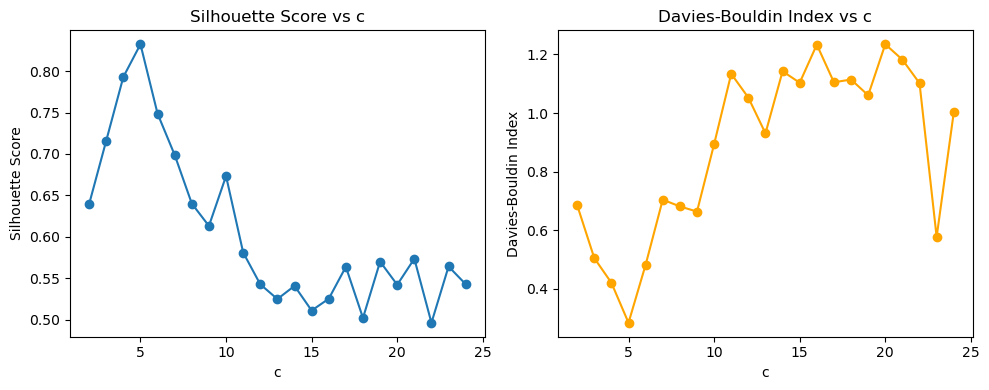


Cluster sizes for final model (chosen by silhouette):
Cluster 0: 300 samples
Cluster 1: 923 samples
Cluster 2: 2849 samples
Cluster 3: 553 samples
Cluster 4: 375 samples


In [34]:
# Plot the metrics
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(c_values, fcm_sil_scores, marker='o')
plt.title('Silhouette Score vs c')
plt.xlabel('c')
plt.ylabel('Silhouette Score')

plt.subplot(1,2,2)
plt.plot(c_values, fcm_db_scores, marker='o', color='orange')
plt.title('Davies-Bouldin Index vs c')
plt.xlabel('c')
plt.ylabel('Davies-Bouldin Index')
plt.tight_layout()
plt.show()

# Fit final model for the silhouette-optimal c and show cluster sizes
final_c = best_c_sil
final_fcm_model = FuzzyCMeans(n_clusters=final_c, m=2, random_state=42)
final_fcm_model.fit(X_scaled_fcm)
final_fcm_labels = final_fcm_model.predict(X_scaled_fcm)
(unique, counts) = np.unique(final_fcm_labels, return_counts=True)
print("\nCluster sizes for final model (chosen by silhouette):")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

---
---
---
---
---
---
---
---
---
---
---
---

# Time Series Analysis: Analyzing trends, seasonality, and anomalies in property prices

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Time Series Analysis: Analyzing trends, seasonality, and anomalies in property prices

# Prepare time series data - aggregate by month
# Convert to time series with mean price per month
ts_data = data_ts_final.groupby(['Sale_Year', 'Sale_Month'])['Price'].agg(['mean', 'count']).reset_index()
ts_data['Date'] = pd.to_datetime(ts_data[['Sale_Year', 'Sale_Month']].assign(Day=1).rename(columns={'Sale_Year': 'year', 'Sale_Month': 'month', 'Day': 'day'}))
ts_data = ts_data.set_index('Date').sort_index()
ts_data.head()

,Sale_Year,Sale_Month,mean,count
Date,,,,
2010-01-01,2010,1,324324.451877,570
2010-02-01,2010,2,317431.648152,709
2010-03-01,2010,3,303389.898841,820
2010-04-01,2010,4,297424.442479,827
2010-05-01,2010,5,289326.789312,843


In [36]:
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Describing Trends for the ARIMA model

# Uses ts_data (mean price per month)

import matplotlib.pyplot as plt

# Prepare monthly series (ensure proper monthly index)
ts = ts_data['mean'].copy()
ts = ts.asfreq('MS')                     # set monthly start freq, will introduce NaNs for missing months
ts = ts.interpolate(method='time')       # fill short gaps by time interpolation (alternatively .ffill/.bfill)

print("Time series summary:")
print(ts.describe())

Time series summary:
count       190.000000
mean     384137.514027
std      105972.687097
min      222827.121199
25%      294404.435277
50%      361929.997199
75%      467032.481204
max      690753.840057
Name: mean, dtype: float64


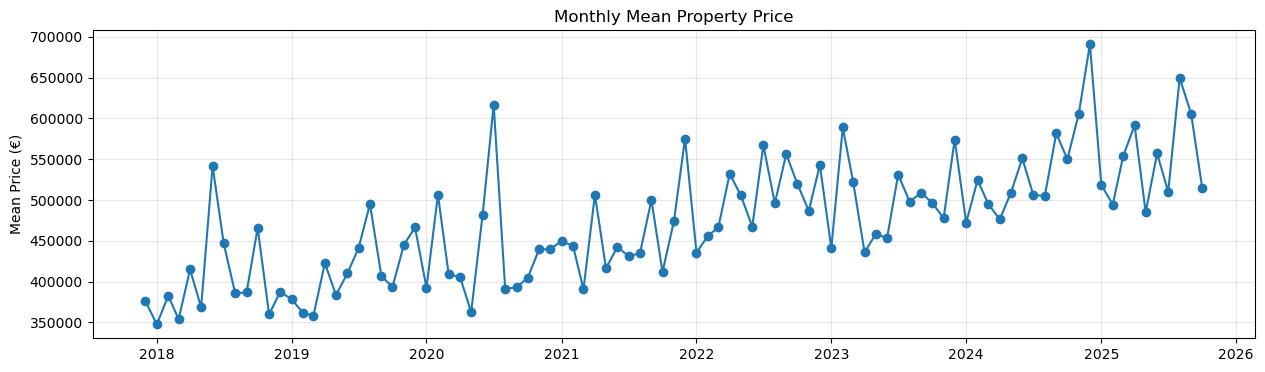

In [37]:
# Plot raw series
plt.figure(figsize=(15,4))
plt.plot(ts.tail(int(0.5*len(ts))), marker='o', linestyle='-') # plot last 50% of data
plt.title('Monthly Mean Property Price')
plt.ylabel('Mean Price (€)')
plt.grid(alpha=0.3)
plt.show()

In [38]:
# Stationarity test (ADF)
adf_res = adfuller(ts.dropna())
print("\nAugmented Dickey-Fuller test:")
print(f"  Test Statistic: {adf_res[0]:.4f}")
print(f"  p-value: {adf_res[1]:.4f}")
for k, v in adf_res[4].items():
    print(f"  Crit. Value ({k}): {v:.4f}")


Augmented Dickey-Fuller test:
  Test Statistic: 0.9581
  p-value: 0.9938
  Crit. Value (1%): -3.4681
  Crit. Value (5%): -2.8781
  Crit. Value (10%): -2.5756


In [39]:
# Decide differencing (d)
if adf_res[1] > 0.05:
    print("\nSeries appears non-stationary (p > 0.05). Applying first difference and re-testing.")
    ts_diff = ts.diff().dropna()
    adf_res_diff = adfuller(ts_diff)
    print(f"  After 1st diff, p-value: {adf_res_diff[1]:.4f}")
    d = 1 if adf_res_diff[1] <= 0.05 else 1  # keep d=1 as a sensible default if still ambiguous
else:
    print("\nSeries appears stationary (p <= 0.05). No differencing required.")
    ts_diff = ts.copy()
    d = 0


Series appears non-stationary (p > 0.05). Applying first difference and re-testing.
  After 1st diff, p-value: 0.0000



Performing seasonal decomposition (period=12)...


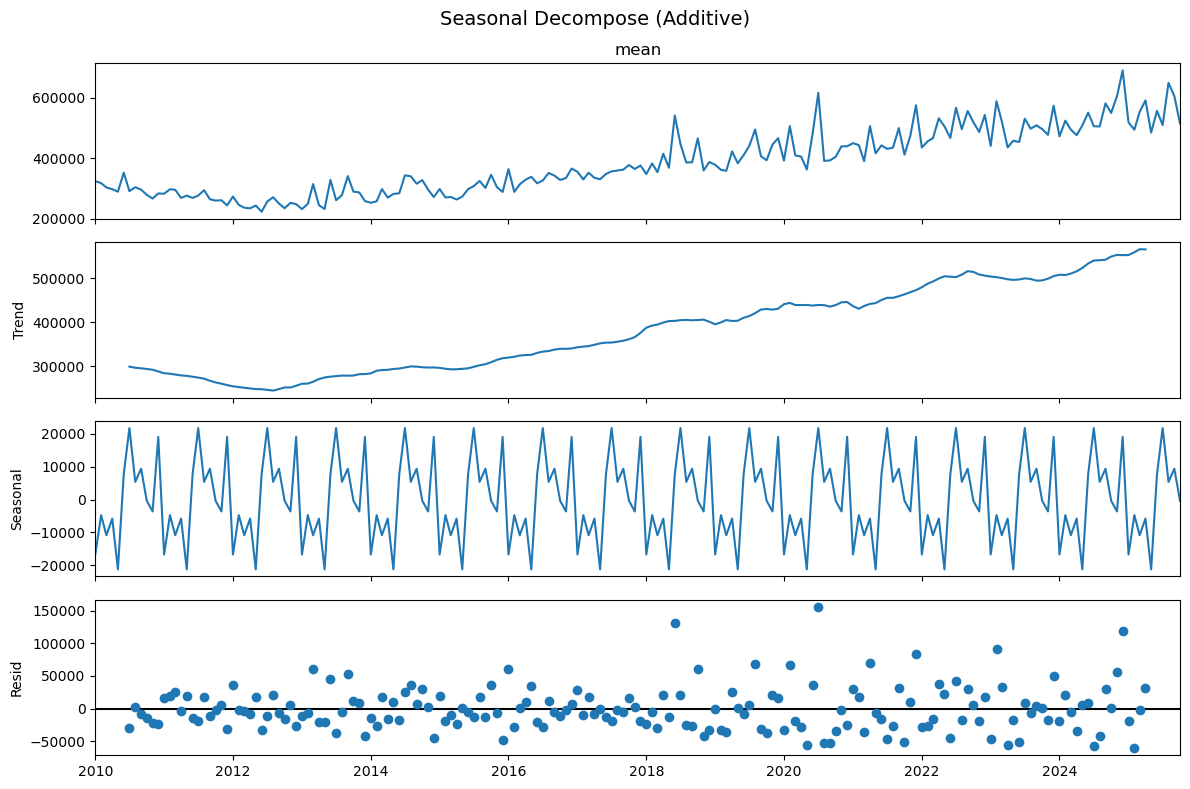

In [40]:
# Seasonal decomposition (assume yearly seasonality with period=12)
print(f"\nPerforming seasonal decomposition (period=12)...")
decomp = seasonal_decompose(ts.dropna(), model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(12,8)
plt.suptitle('Seasonal Decompose (Additive)', fontsize=14)
plt.tight_layout()
plt.show()



ACF / PACF plots (lags up to 24):


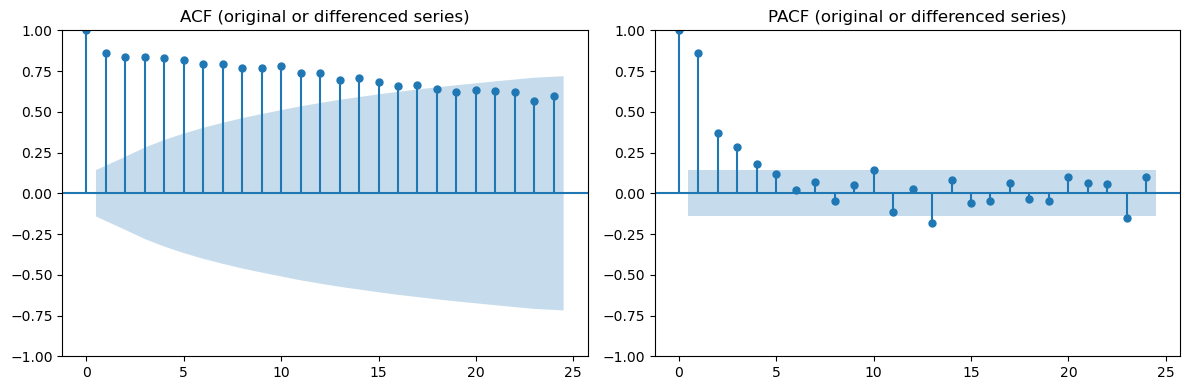

In [41]:
# ACF & PACF plots for identification of p and q
print("\nACF / PACF plots (lags up to 24):")
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(ts.dropna(), lags=24, ax=plt.gca())
plt.title('ACF (original or differenced series)')

plt.subplot(1,2,2)
plot_pacf(ts.dropna(), lags=24, ax=plt.gca(), method='ywm')
plt.title('PACF (original or differenced series)')
plt.tight_layout()
plt.show()

In [42]:
# Compute numeric ACF/PACF values for a simple heuristic to suggest p and q
ts_for_ac = (ts_diff if d == 1 else ts).dropna()
n = len(ts_for_ac)
acf_vals = acf(ts_for_ac, nlags=24, fft=False)
pacf_vals = pacf(ts_for_ac, nlags=24, method='ywm')

# significance threshold (approximate) for lag correlation
# The value 1.96 comes from the standard normal distribution (Z-distribution) and represents the critical value for a 95% confidence level
sig_thresh = 1.96 / np.sqrt(n)

In [43]:

# Heuristic: first lag where PACF drops inside the significance band => suggested p
p_suggest = None
for lag in range(1, len(pacf_vals)):
    if abs(pacf_vals[lag]) < sig_thresh:
        p_suggest = lag - 1 if lag - 1 >= 0 else 0
        break
if p_suggest is None:
    p_suggest = 1

In [44]:
# Heuristic: first lag where ACF drops inside the band => suggested q
q_suggest = None
for lag in range(1, len(acf_vals)):
    if abs(acf_vals[lag]) < sig_thresh:
        q_suggest = lag - 1 if lag - 1 >= 0 else 0
        break
if q_suggest is None:
    q_suggest = 1

In [45]:
#pritn suggested p, d, q values
print(f"\nSuggested ARIMA parameters based on ACF/PACF heuristics:")
print(f"  p (AR order): {p_suggest}")
print(f"  d (differencing order): {d}")
print(f"  q (MA order): {q_suggest}")


Suggested ARIMA parameters based on ACF/PACF heuristics:
  p (AR order): 4
  d (differencing order): 1
  q (MA order): 1


In [46]:
from statsmodels.tsa.arima.model import ARIMA

# If you want to specify custom parameters, change the order tuple
model = ARIMA(ts, order=(p_suggest, d, q_suggest))
fitted_model = model.fit()

print(f"ARIMA({p_suggest}, {d}, {q_suggest}) model fitted successfully")
print("\nModel Summary:")
print(fitted_model.summary())

ARIMA(4, 1, 1) model fitted successfully

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   mean   No. Observations:                  190
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -2290.046
Date:                Sat, 25 Oct 2025   AIC                           4592.093
Time:                        23:45:58   BIC                           4611.543
Sample:                    01-01-2010   HQIC                          4599.973
                         - 10-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0244      0.147      0.166      0.868      -0.263       0.312
ar.L2         -0.0916      0.109     -0.843      0.399      -0.304       0

ARIMA(4, 1, 1) model fitted on training data.

ARIMA Model Evaluation on Test Data:
  R-squared (R2): -0.2751
  Mean Absolute Error (MAE): 45,286.61
  Mean Squared Error (MSE): 3,844,684,379.14
  Root Mean Squared Error (RMSE): 62,005.52


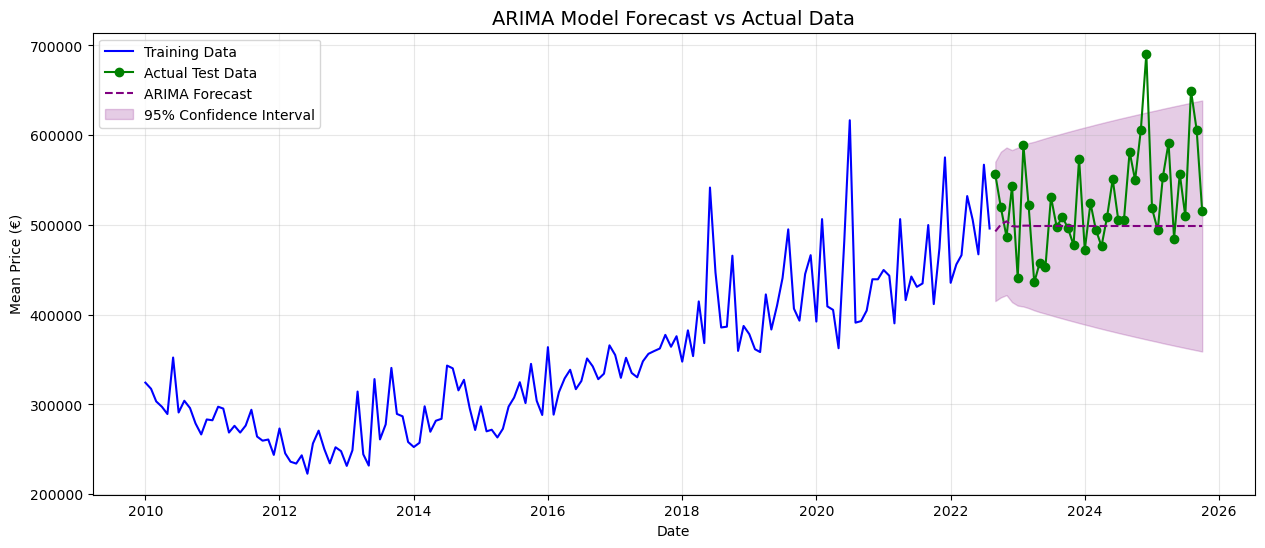

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

# To evaluate the ARIMA model's forecasting capability, we'll use the same train/test split
# as the SARIMA model for a fair comparison.

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(ts) * 0.8)
train_data = ts[:train_size]
test_data = ts[train_size:]
forecast_steps = len(test_data)

# Fit the ARIMA model on the training data only
arima_train_model = ARIMA(train_data, order=(p_suggest, d, q_suggest))
arima_train_fitted = arima_train_model.fit()

print(f"ARIMA({p_suggest}, {d}, {q_suggest}) model fitted on training data.")

# Generate forecast for the test period
forecast = arima_train_fitted.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate the forecast
mae = mean_absolute_error(test_data, forecast_values)
mse = mean_squared_error(test_data, forecast_values)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, forecast_values)

print("\nARIMA Model Evaluation on Test Data:")
print(f"  R-squared (R2): {r2:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:,.2f}")
print(f"  Mean Squared Error (MSE): {mse:,.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:,.2f}")

# Plot the forecast against the actual data
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='green', marker='o')
plt.plot(test_data.index, forecast_values, label='ARIMA Forecast', color='purple', linestyle='--')
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='purple', alpha=0.2, label='95% Confidence Interval')
plt.title('ARIMA Model Forecast vs Actual Data', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Mean Price (€)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# SARIMA

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [49]:
# Fit SARIMA model with seasonal parameters
# Based on the decomposition, we observed yearly seasonality (period=12)
# Using the ARIMA parameters identified earlier plus seasonal component

# SARIMA parameters: (p,d,q) x (P,D,Q,s)
# Non-seasonal: (p_suggest, d, q_suggest) = (4, 1, 1)
# Seasonal: (P, D, Q, s) where s=12 for monthly data
# P, D, Q are seasonal equivalents of p, d, q

# Start with simple seasonal parameters
P = 1  # Seasonal AR order
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA order
s = 12 # Seasonal period (monthly data, yearly pattern)

print(f"Fitting SARIMA model with parameters:")
print(f"  Non-seasonal (p,d,q): ({p_suggest}, {d}, {q_suggest})")
print(f"  Seasonal (P,D,Q,s): ({P}, {D}, {Q}, {s})")

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(ts) * 0.8)
train_data = ts[:train_size]
test_data = ts[train_size:]
forecast_steps = len(test_data)

print(f"\nTrain data: {len(train_data)} months")
print(f"Test data: {len(test_data)} months")
print(f"Forecast steps: {forecast_steps}")


# Fit SARIMA model on training data
sarima_model = SARIMAX(train_data, 
                       order=(p_suggest, d, q_suggest),
                       seasonal_order=(P, D, Q, s),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fitted = sarima_model.fit(disp=False)

print("\nSARIMA Model Summary:")
print(sarima_fitted.summary())

Fitting SARIMA model with parameters:
  Non-seasonal (p,d,q): (4, 1, 1)
  Seasonal (P,D,Q,s): (1, 1, 1, 12)

Train data: 152 months
Test data: 38 months
Forecast steps: 38

SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                               mean   No. Observations:                  152
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1489.214
Date:                            Sat, 25 Oct 2025   AIC                           2994.428
Time:                                    23:45:59   BIC                           3016.926
Sample:                                01-01-2010   HQIC                          3003.566
                                     - 08-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975

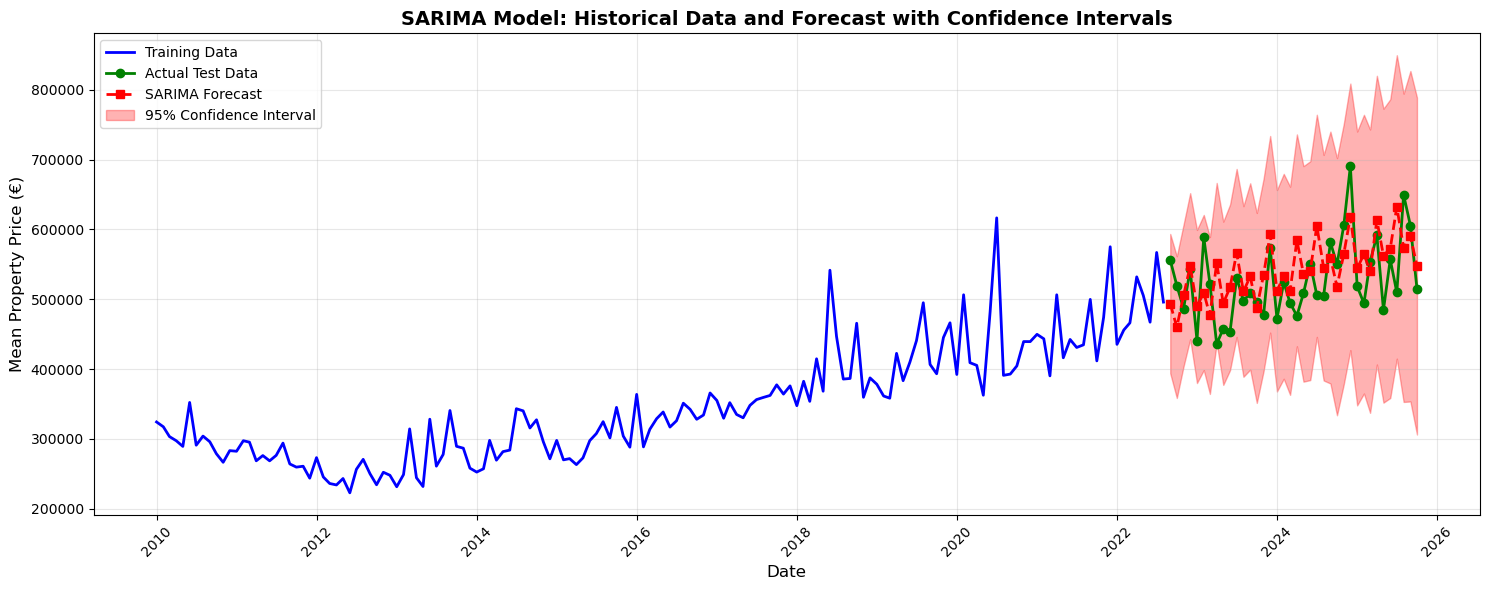

In [50]:
# Plot SARIMA forecast with confidence intervals
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))

# Get forecast with confidence intervals
sarima_forecast_ci = sarima_fitted.get_forecast(steps=forecast_steps)
forecast_df = sarima_forecast_ci.summary_frame(alpha=0.05)  # 95% confidence interval
sarima_forecast_values = sarima_forecast_ci.predicted_mean.values

# Plot historical data
ax1.plot(train_data.index, train_data.values, label='Training Data', color='blue', linewidth=2)
ax1.plot(test_data.index, test_data.values, label='Actual Test Data', color='green', linewidth=2, marker='o')

# Plot SARIMA forecast
ax1.plot(test_data.index, sarima_forecast_values, label='SARIMA Forecast', 
         color='red', linewidth=2, linestyle='--', marker='s')

# Plot confidence intervals
ax1.fill_between(test_data.index, 
                 forecast_df['mean_ci_lower'].values,
                 forecast_df['mean_ci_upper'].values,
                 alpha=0.3, color='red', label='95% Confidence Interval')

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Mean Property Price (€)', fontsize=12)
ax1.set_title('SARIMA Model: Historical Data and Forecast with Confidence Intervals', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [51]:
test_data.shape

(38,)

In [52]:
sarima_forecast_values.shape

(38,)

In [53]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Evaluate the forecast against the actual test data

mae = mean_absolute_error(test_data, sarima_forecast_values)
mse = mean_squared_error(test_data, sarima_forecast_values)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, sarima_forecast_values)

print("SARIMA Model Evaluation on Test Data:")
print(f"  R-squared (R2): {r2:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:,.2f}")
print(f"  Mean Squared Error (MSE): {mse:,.2f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:,.2f}")

SARIMA Model Evaluation on Test Data:
  R-squared (R2): 0.0210
  Mean Absolute Error (MAE): 44,267.15
  Mean Squared Error (MSE): 2,951,893,103.01
  Root Mean Squared Error (RMSE): 54,331.33


In [54]:

# Create a dataframe to store r2 score
evaluation_results = pd.DataFrame({'r2_score': r2_score(test_data, sarima_forecast_values)}, index=[0])

# Add columns in the dataframe 'evaluation_results'
evaluation_results['mean_absolute_error'] = mean_absolute_error(test_data, sarima_forecast_values)
evaluation_results['mean_squared_error'] = mean_squared_error(test_data, sarima_forecast_values)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test_data, sarima_forecast_values))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(sarima_forecast_values - test_data) / np.abs(test_data)) * 100

# Display the results
evaluation_results



,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.021019,44267.152211,2.951893e+09,54331.327087,8.606229


# Anomalies 

In [55]:
# Anomaly Detection using ARIMA residuals

# Use the fitted ARIMA model to detect anomalies in the time series
# Anomalies are identified as observations where the residual (actual - predicted) 
# exceeds a threshold (typically 2-3 standard deviations)

# Get fitted values and residuals from the full dataset model
fitted_values = fitted_model.fittedvalues
residuals = fitted_model.resid

# Calculate threshold for anomaly detection (2 standard deviations)
residual_std = residuals.std()
threshold = 2 * residual_std

# Identify anomalies
anomalies = np.abs(residuals) > threshold
anomaly_dates = ts[anomalies].index
anomaly_values = ts[anomalies].values
anomaly_residuals = residuals[anomalies].values

print(f"Anomaly Detection Results:")
print(f"Total observations: {len(ts)}")
print(f"Number of anomalies detected: {anomalies.sum()}")
print(f"Percentage of anomalies: {(anomalies.sum() / len(ts)) * 100:.2f}%")
print(f"Residual standard deviation: {residual_std:,.2f}")
print(f"Anomaly threshold (±2σ): ±{threshold:,.2f}")

# Display anomalies
print("\nDetected Anomalies:")
anomaly_df = pd.DataFrame({
    'Date': anomaly_dates,
    'Actual_Price': anomaly_values,
    'Fitted_Price': fitted_values[anomalies].values,
    'Residual': anomaly_residuals,
    'Abs_Residual': np.abs(anomaly_residuals)
}).sort_values('Abs_Residual', ascending=False)

Anomaly Detection Results:
Total observations: 190
Number of anomalies detected: 8
Percentage of anomalies: 4.21%
Residual standard deviation: 49,295.14
Anomaly threshold (±2σ): ±98,590.27

Detected Anomalies:


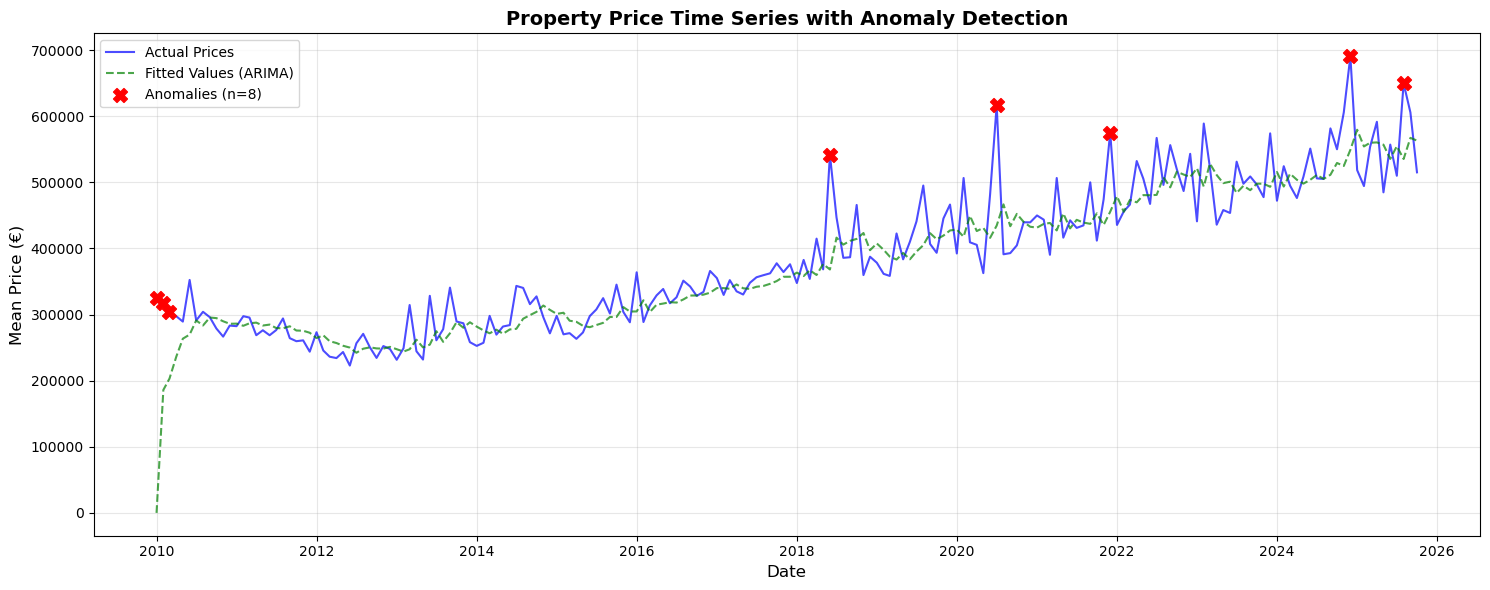

In [56]:
# Visualization for Anomaly Detection

# Create a comprehensive visualization of anomalies in the time series
fig, ax = plt.subplots(figsize=(15, 6))

# Time series with anomalies highlighted
ax.plot(ts.index, ts.values, label='Actual Prices', color='blue', linewidth=1.5, alpha=0.7)
ax.plot(fitted_values.index, fitted_values.values, label='Fitted Values (ARIMA)', 
    color='green', linewidth=1.5, linestyle='--', alpha=0.7)
ax.scatter(anomaly_dates, anomaly_values, color='red', s=100, 
       label=f'Anomalies (n={len(anomaly_dates)})', zorder=5, marker='X')
ax.set_title('Property Price Time Series with Anomaly Detection', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Mean Price (€)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
